# Main

In [1]:
import picIEEE
import matplotlib.pyplot as plt
import math
import sounddevice as sd
import numpy as np

# This is directory containing "data" and "labels" folders
datasetsFolder = r"D:\Google Drive\PAPERS\1 - WIP - Work In Progress\(IEEE) - Machine Learning Contest\Datasets\L3DAS_Task2_train"

# Fetching the name of all samples in the given directory
dsNames = picIEEE.getDatasetNames(datasetsFolder)

### Accessing metadata

In [2]:
# Getting one of the samples in the dataset
ambiSample = picIEEE.AmbiIeeeSample(datasetsFolder, dsNames[0])

# Accessing meta...
ambiTable = ambiSample.getMetaData()
ambiTable

,File,Start,End,Class,X,Y,Z,R,Elev,Azimut,StartSample,EndSample
0,0,0.547844,9.665094,Writing,0.50,-1.50,0.3,1.609348,79.256596,-71.565051,17531,309283
1,0,11.520750,12.534219,Finger_snapping,0.75,1.25,-1.0,1.767767,124.449902,59.036243,368664,401095
2,0,14.255219,16.063562,Keys_jangling,0.50,-1.50,0.3,1.609348,79.256596,-71.565051,456167,514034
3,0,17.727844,18.877594,Chink_and_clink,0.50,1.00,0.0,1.118034,90.000000,63.434949,567291,604083
4,0,19.950156,20.400125,Printer,-1.50,-1.50,-0.6,2.204541,105.793169,-135.000000,638405,652804
5,0,20.993906,23.477000,Cupboard_open_or_close,-0.50,0.75,0.0,0.901388,90.000000,123.690068,671805,751264
6,0,25.031844,25.723375,Chink_and_clink,-2.00,-0.50,-0.3,2.083267,98.279643,-165.963757,801019,823148
7,0,26.547125,27.490813,Female_speech_and_woman_speaking,1.00,-1.50,0.0,1.802776,90.000000,-56.309932,849508,879706
8,0,28.158625,30.611406,Knock,1.00,1.50,0.0,1.802776,90.000000,56.309932,901076,979565
9,0,31.893656,33.058062,Chink_and_clink,0.50,-1.25,-1.0,1.677051,126.604276,-68.198591,1020597,1057858


### Plotting audio events

<IPython.core.display.Javascript object>


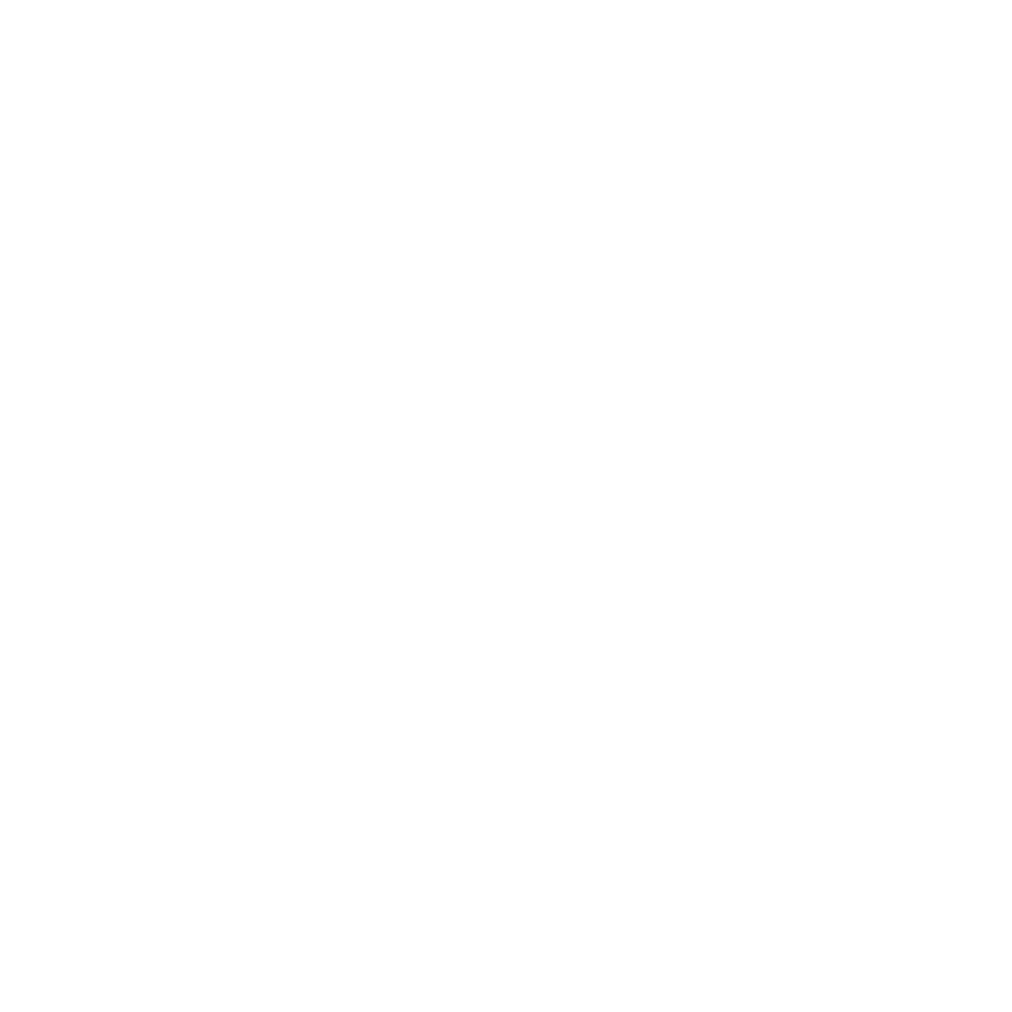

In [3]:
# Importing 3d axes, creating and formatting figure.
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("Events")

# Creating text annotations
for row in ambiTable.iterrows():
    ax.text(
    row[1]['X'], row[1]['Y'], row[1]['Z'], 
        "{}: {}\n Az:{}º\n El:{}º".format(
            row[0], 
            row[1]['Class'][0:10], 
            round(row[1]['Azimut'], ndigits=2), 
            round(row[1]['Elev'], ndigits=2)), 
        ha="center", va="center",
        bbox=dict(boxstyle="round4,pad=0.3"))

# Plots points where annotations would be
ax.scatter(ambiTable['X'], ambiTable['Y'], ambiTable['Z'])

plt.show()



### Loading the audio file
The audio vectors become two additional columns in the metadata table: "MicA" and "MicB"

In [4]:
ambiTable = ambiSample.getAudioData()

### The next cell contains the function to convert ambisonics to L-R channels, considering cardioid patterns

In [5]:
def ambisonicsToLR(ambisonicsSignal):
    # Defining left and right angles and directivity pattern
    micLeftAngle = math.pi / 2
    micRightAngle = -math.pi / 2
    p = 0.5 # Directivity pattern (cardioid)

    # Separating each ambisonics channel
    W = ambisonicsSignal[:, 0]
    X = ambisonicsSignal[:, 1]
    Y = ambisonicsSignal[:, 2]
    Z = ambisonicsSignal[:, 3]

    # Calculating left channel as a horizontal microphone directed to the left
    leftSignal = p * math.sqrt(2) * W
    + ((1 - p) 
    * ((math.cos(micLeftAngle) * X) 
       + (math.sin(micLeftAngle) * Y)))

    # Doing the same for the right side
    rightSignal = p * math.sqrt(2) * W
    + ((1 - p) 
    * ((math.cos(micRightAngle) * X) 
       + (math.sin(micRightAngle) * Y)))
    
    # Joining both channels into a single numpy
    L = np.asmatrix(leftSignal)
    R = np.asmatrix(rightSignal)
    LR = np.concatenate((L, R), axis=0)
    LR = LR.transpose()
    
    # Converting its data type back to int16
    LR = np.asarray(LR, dtype=np.int16)
    
    return LR



## Run this cell to play the signal (check your inputs)

<IPython.core.display.Javascript object>


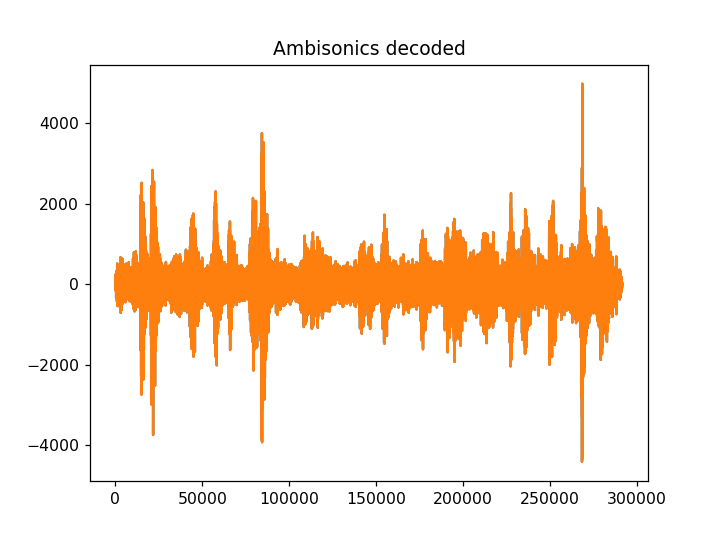

In [7]:
# Ambisonics signal input...
ambisonicsSignal = ambiTable['MicA'][0]
samplingFrequency = 32000

# Converting from ambi to LR and playing...
LR = ambisonicsToLR(ambisonicsSignal)
sd.play(LR, samplingFrequency)

# Plotting the converted LR signal
plt.figure()
plt.title("Ambisonics decoded")
plt.plot(LR)
plt.show()